<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/agc_attack_detection_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Loading & Plotting

Load and plot the training data

           0           0.1           0.2           0.3
0        1.0  0.000000e+00  0.000000e+00  0.000000e+00
1        2.0  0.000000e+00  0.000000e+00  0.000000e+00
2        3.0  0.000000e+00  0.000000e+00  0.000000e+00
3        4.0  0.000000e+00  0.000000e+00  0.000000e+00
4        5.0  0.000000e+00  0.000000e+00  0.000000e+00
...      ...           ...           ...           ...
4188  3996.0 -1.020800e-08  1.020900e-08  7.224600e-09
4189  3997.0 -9.448000e-09  9.448400e-09  6.713700e-09
4190  3998.0 -8.750700e-09  8.751000e-09  6.240600e-09
4191  3999.0 -8.111500e-09  8.111800e-09  5.802300e-09
4192  4000.0 -7.525400e-09  7.525600e-09  5.395900e-09

[4193 rows x 4 columns]


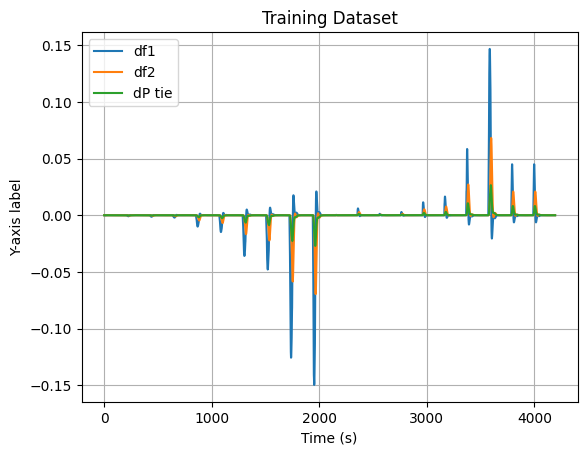

In [2]:
train_dataset_df = pd.read_csv('train_dataset.csv', dtype=np.float32)
print(train_dataset_df)
# train_dataset_df = train_dataset_df[train_dataset_df.index % 10 == 0]
# print(train_dataset_df)

plt.figure()
plt.plot(train_dataset_df.iloc[:, 1], label='df1')
plt.plot(train_dataset_df.iloc[:, 2], label='df2')
plt.plot(train_dataset_df.iloc[:, 3], label='dP tie')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

Load and plot the testing data

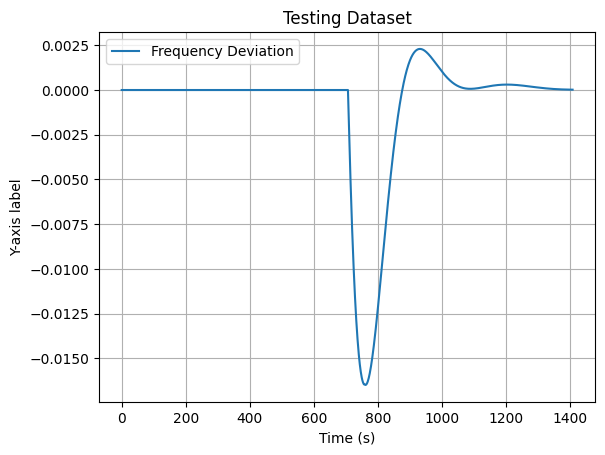

In [76]:
test_dataset_df = pd.read_csv('test_dataset.csv', dtype=np.float32)
# test_dataset_df = test_dataset_df[test_dataset_df.index % 10 == 0]

plt.figure()
plt.plot(test_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Testing Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Data preprocess

**Pipeline description**:

csv format →  data frame → numpy → tensor

In [3]:
def windowed_array(arr, window_size):
    # Calculate the number of subarrays
    num_windows = len(arr) - window_size

    # Create an empty array to store the result
    result = np.empty((num_windows, window_size), dtype=arr.dtype)

    # Fill the result array with windowed slices
    for i in range(num_windows):
        result[i] = arr[i:i+window_size]

    return result

class CustomDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = torch.tensor(inputs)

    def __len__(self):
        return len(self.inputs)  # Assuming all arrays have the same length

    def __getitem__(self, index):
        return self.inputs[index]

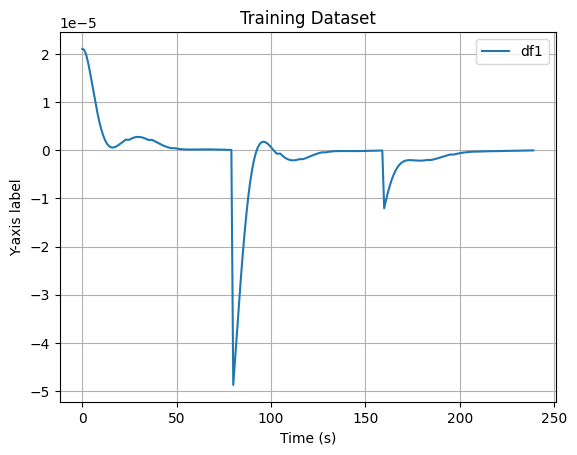

In [7]:
# HYPERPARAMETER - select the window size
window = 80

# training data preprocess

df1 = train_dataset_df.iloc[:, 1].to_numpy()
df2 = train_dataset_df.iloc[:, 2].to_numpy()
dptie = train_dataset_df.iloc[:, 3].to_numpy()

df1 = windowed_array(df1, window)
df2 = windowed_array(df2, window)
dptie = windowed_array(dptie, window)

# X_train size: (dataset_rows - window) x (window x features)
X_train = np.concatenate((df1, df2, dptie), axis=1)

plt.figure()
plt.plot(X_train[30], label='df1')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

train_tensor = CustomDataset(X_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

# testing data preprocess

# X_test = test_dataset_df.iloc[:, 1].to_numpy()

# X_test = windowed_array(X_test, window)
# y_test = windowed_array(y_test, window)

# test_tensor = CustomDataset(X_test, y_test)
# test_loader = DataLoader(test_tensor, batch_size=64, shuffle=True)

Definition & initilization of MLP

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )

        self.decoder = torch.nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
# define feedforward neural network architecture
input_size = X_train.shape[1]

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = AutoEncoder(input_size)
net = nn.DataParallel(net)
net = net.to(device)

# define loss function and optimizer
criterion = nn.MSELoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.SGD(net.parameters(), lr=0.5)

Training of MLP

In [20]:
# Initialize the parameters of the model
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        nn.init.zeros_(module.bias)

In [ ]:
epochs = 150
training_loss = []

# Apply initialization to the model
net.apply(initialize_weights)

for e in range(epochs):

    total_batch_loss = 0.0
    average_batch_loss = 0.0

    # forward pass
    for i_batch, input_batch in enumerate(train_loader):

        input_batch = input_batch.to(device)

        # nullify gradients for every batch
        optimizer.zero_grad()

        output = net(input_batch)

        # compute loss and store the total loss in each epoch
        loss = criterion(output, input_batch)
        total_batch_loss += loss.item()

        # backpropagation
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

    average_batch_loss = total_batch_loss / len(train_loader)
    training_loss.append(average_batch_loss)

    print('Epoch [{}/{}], Loss: {}'.format(e+1, epochs, average_batch_loss))

Plot training loss

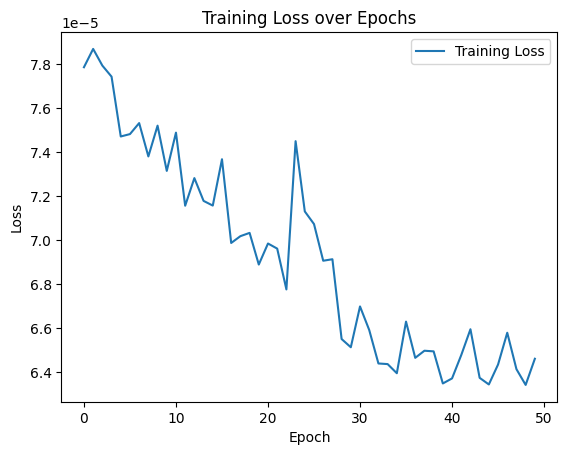

In [17]:
# Plot the training loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Model evaluation

tensor([-0.0161, -0.0161, -0.0162, -0.0163, -0.0163, -0.0164, -0.0164, -0.0164,
        -0.0164, -0.0164, -0.0165, -0.0165, -0.0165, -0.0165, -0.0165, -0.0164,
        -0.0164, -0.0164, -0.0163, -0.0163])
tensor([0.0096, 0.0102, 0.0101, 0.0103, 0.0100, 0.0102, 0.0102, 0.0103, 0.0097,
        0.0100, 0.0098, 0.0101, 0.0104, 0.0103, 0.0101, 0.0099, 0.0099, 0.0099,
        0.0099, 0.0101])


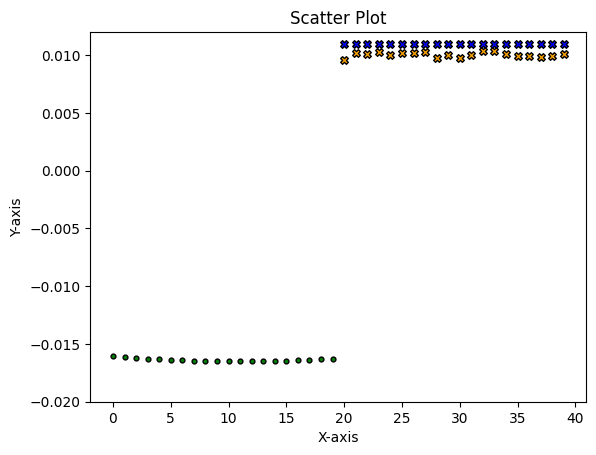

In [ ]:
for i, (test_input, test_target) in enumerate(test_tensor):
    if i == 750:
        with torch.no_grad():

            print(test_input)
            predicted = net(test_input)
            print(predicted)

            test_input = test_input.numpy()
            test_target = test_target.numpy()
            predicted = predicted.detach().numpy()

            t_max = len(test_target) + len(test_target)
            t = np.arange(0, t_max)

            # Plot dots
            plt.scatter(t[:len(test_input)], test_input, color='green', edgecolors='black', s=12)
            plt.scatter(t[len(predicted):], predicted, color='orange', marker='X', edgecolors='black', s=30)
            plt.scatter(t[len(test_target):], test_target, color='blue', marker='X', edgecolors='black', s=30)

            plt.ylim(-0.02, 0.012)

            # Set labels and title
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('Scatter Plot')

            # Show plot
            plt.show()

In [49]:
array1 = np.zeros((2, 3))
array2 = np.ones((2, 3))
array3 = np.random.rand(2, 3)

merged_array = np.concatenate((array1, array2, array3), axis=1)

print(merged_array)

[[0.         0.         0.         1.         1.         1.
  0.52645837 0.04876322 0.29750942]
 [0.         0.         0.         1.         1.         1.
  0.75761057 0.68017135 0.26157594]]
